# CNN 卷积神经网络

- 输入层：输入图像等信息，作用就是将图像转换为其对应的由像素值构成的二维矩阵，并将此二维矩阵存储，等待后面几层的操作。
- 卷积层：用来提取图像的底层特征。
  ![](./image/卷积.gif)
  - padding：为保证边缘和中心特征提取一致，卷积时向外拓展padding圈
    ![](./image/padding.gif)
- 池化层：防止过拟合，将数据维度减小。当我们进行卷积操作后，再将得到的特征图进行特征提取，将其中最具有代表性的特征提取出来，可以起到减小过拟合和降低维度的作用；为卷积神经网络带来平移不变性。
  - 最大池化：maxpool，选取正方形中最大值。
    - kernel_size：卷积核大小
    - stride：步长
    - padding：填充
  - 平均池化：选取平均数向上取整
- 全连接层：汇总卷积层和池化层得到的图像的底层特征和信息
- 输出层：根据全连接层的信息得到概率最大的结果

**注意区别卷积层+池化层和全连接层的输入输出通道数区别，以及计算方式**



## Step1：导入数据集
使用torchvision.transfroms和datasets中的MNIST作为数据集
进行数据增强

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
import torch

import matplotlib.pyplot as plt
train_data=datasets.MNIST(root='data',train=True,download=True,transform=transforms.ToTensor())
test_data=datasets.MNIST(root='data',train=False,download=True,transform=transforms.ToTensor())

# 随机数据增强
transform = transforms.Compose(
    [transforms.Resize([128, 128]),
     transforms.RandomRotation(degrees=2.0),
     transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.5, hue=0.4),
     transforms.RandomCrop(size=[128, 128], padding=4),
     transforms.ToTensor()
  ])

train_loader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)

# Step2:构建模型

构建CNN网络

- nn.Conv2d为卷积层
  - in_channels：输入数据的通道数
  - out_channels：输出数据的通道数（卷积核数量）
  - kernel_size：卷积核大小
  - stride：卷积移动步长
  - padding：填充
  
- nn.BatchNorm2d为归一化层，用于保证参数的分布归一化
- nn.Maxpool2d为池化层，kernel_size规定核
- ReLU为激活层

注意全连接层中第一层输入数的计算方式。


In [8]:
import torch.nn as nn
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer2=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1=nn.Linear(1152,128)
        self.fc2=nn.Linear(128,10)

    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out
    




## Step 3: 训练模型
- 使用cuda
- 建立模型
- 设定优化器Adam/SGD/...(在优化器中传入model.parameters()，学习率)
- 训练10个epoch
  - 在训练模式下首先使优化器梯度为0，然后loss定义为crossEntropy（即判断最后的十维向量与正确label的交叉熵），然后反向传播和按照梯度下降
  - 在测试模式下，基本同样的过程。

Epoch:0[0/60000(0%)]	Loss:2.316546
Epoch:0[6400/60000(11%)]	Loss:0.148646
Epoch:0[12800/60000(21%)]	Loss:0.368640
Epoch:0[19200/60000(32%)]	Loss:0.040378
Epoch:0[25600/60000(43%)]	Loss:0.004916
Epoch:0[32000/60000(53%)]	Loss:0.080448
Epoch:0[38400/60000(64%)]	Loss:0.010835
Epoch:0[44800/60000(75%)]	Loss:0.025117
Epoch:0[51200/60000(85%)]	Loss:0.178083
Epoch:0[57600/60000(96%)]	Loss:0.045461
Test set: Average loss:0.0009,Accuracy:9815/10000(98%)
Epoch:1[0/60000(0%)]	Loss:0.056766
Epoch:1[6400/60000(11%)]	Loss:0.084689
Epoch:1[12800/60000(21%)]	Loss:0.093581
Epoch:1[19200/60000(32%)]	Loss:0.019433
Epoch:1[25600/60000(43%)]	Loss:0.071913
Epoch:1[32000/60000(53%)]	Loss:0.011423
Epoch:1[38400/60000(64%)]	Loss:0.006656
Epoch:1[44800/60000(75%)]	Loss:0.008336
Epoch:1[51200/60000(85%)]	Loss:0.112693
Epoch:1[57600/60000(96%)]	Loss:0.024009
Test set: Average loss:0.0010,Accuracy:9809/10000(98%)
Epoch:2[0/60000(0%)]	Loss:0.242971
Epoch:2[6400/60000(11%)]	Loss:0.010360
Epoch:2[12800/60000(21%)]	Lo

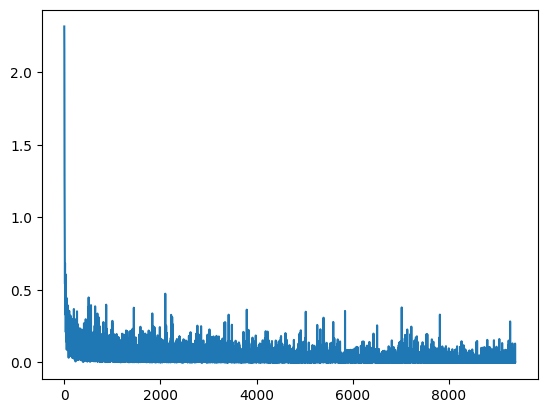

In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model=Model().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

losses=[]
for epoch in range(10):
    model.train()
    for (batch_idx,(data,target)) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)

        optimizer.zero_grad()
        output=model(data)
        loss=nn.CrossEntropyLoss()(output,target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Epoch:{}[{}/{}({:.0f}%)]\tLoss:{:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    model.eval()
    test_loss=0
    correct=0
    with torch.no_grad():
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=model(data)
            test_loss+=nn.CrossEntropyLoss()(output,target).item()
            pred=output.argmax(dim=1,keepdim=True)
            correct+=pred.eq(target.view_as(pred)).sum().item()
    print('Test set: Average loss:{:.4f},Accuracy:{}/{}({:.0f}%)'.format(
        test_loss/len(test_loader.dataset),correct,len(test_loader.dataset),
        100.*correct/len(test_loader.dataset)
    ))

plt.plot(losses)
plt.show()
